# Contents
* [Introduction](#Introduction)
* [Imports and configuration](#Imports-and-configuration)
* [Setup](#Setup)
* [n_estimators](#n_estimators)
* [max_depth](#max_depth)
* [min_samples_split](#min_samples_split)
* [min_samples_leaf](#min_samples_leaf)
* [max_leaf_nodes](#max_leaf_nodes)
* [Prototype](#Prototype)
* [Discussion](#Discussion)

# Introduction

After rounds of feature engineering, visualization & exploration, and tuning various aspects of the classification pipeline, we are about to create a benchmark prototype classifier using RandomForestClassifier. In this notebook, we perform a grid search over n_estimators using out-of-bag accuracy instead of cross validation. Other hyperparameters are based on previous 5-fold cross-validation using a related set of features.

In [1]:
from time import time

notebook_begin_time = time()

# set random seeds

from os import environ
from random import seed as random_seed
from numpy.random import seed as np_seed
from tensorflow.random import set_seed


def reset_seeds(seed: int) -> None:
    """Utility function for resetting random seeds"""
    environ["PYTHONHASHSEED"] = str(seed)
    random_seed(seed)
    np_seed(seed)
    set_seed(seed)


reset_seeds(SEED := 2021)
del environ
del random_seed
del np_seed
del set_seed
del reset_seeds

In [2]:
# extensions
%load_ext autotime
%load_ext lab_black
%load_ext nb_black

In [3]:
# core
import pandas as pd

# utility
from gc import collect as gc_collect
from tqdm.notebook import tqdm

# faster sklearn
from sklearnex import patch_sklearn

patch_sklearn()
del patch_sklearn

# classifier
from sklearn.ensemble import RandomForestClassifier

# metrics
from sklearn.metrics import log_loss, roc_auc_score

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set_context("notebook")

# full display of rows and columns
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_rows", None)

# display outputs w/o print calls
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
del InteractiveShell

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


time: 3.59 s


In [4]:
# Location of FRILL .feather files
FRILL_FEATHERS_FOLDER = "../1.0-mic-extract_FRILL_embeddings"

# Location of pre-final features
FEATURES_FOLDER = "../19.0-mic-extract_FRILL-based_features_from_full_data"

# Location where this notebook will output
DATA_OUT_FOLDER = "."

_ = gc_collect()

time: 156 ms


# Setup

In [5]:
def load_labels() -> pd.DataFrame:
    """Load just the labels"""
    keep_columns = [
        "id",
        "source",
        "speaker_id",
        "speaker_gender",
        "emo",
        "valence",
        "lang1",
    ]
    labels = pd.concat(
        (
            pd.read_feather(
                f"{FRILL_FEATHERS_FOLDER}/dev_labels.feather", columns=keep_columns
            ),
            pd.read_feather(
                f"{FRILL_FEATHERS_FOLDER}/nondev_labels.feather", columns=keep_columns
            ),
        )
    ).set_index("id")
    return labels


def load_data(unscaled=False) -> pd.DataFrame:
    """Loads the FRILL-based features"""
    if unscaled:
        df = pd.read_feather(
            f"{FEATURES_FOLDER}/unscaled_features_ready_for_selection.feather"
        ).set_index("id")
    else:
        df = pd.read_feather(
            f"{FEATURES_FOLDER}/features_ready_for_selection.feather"
        ).set_index("id")
    df.columns = df.columns.astype(str)
    return df


data = load_data(unscaled=True)
labels = load_labels()
y_true = labels.valence
assert all(data.index == labels.index)
_ = gc_collect()

time: 381 ms


In [6]:
data.info()
labels.info()

<class 'pandas.core.frame.DataFrame'>
UInt64Index: 86752 entries, 0 to 87363
Columns: 118 entries, theta_LDA1+LDA2 to LDA-ocSVM_poly6_pos
dtypes: float64(118)
memory usage: 78.8 MB
<class 'pandas.core.frame.DataFrame'>
UInt64Index: 86752 entries, 0 to 87363
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   source          86752 non-null  category
 1   speaker_id      86752 non-null  category
 2   speaker_gender  86752 non-null  category
 3   emo             86752 non-null  category
 4   valence         86752 non-null  int8    
 5   lang1           86752 non-null  category
dtypes: category(5), int8(1)
memory usage: 1.3 MB
time: 29 ms


# n_estimators

  0%|          | 0/499 [00:00<?, ?it/s]

     n_estimators  oob_score  log_loss     auroc
340           342   0.929085  0.085561  0.999723
339           341   0.929062  0.085574  0.999723
341           343   0.929062  0.085579  0.999723
338           340   0.929062  0.085580  0.999723
348           350   0.929051  0.085542  0.999723
361           363   0.929051  0.085564  0.999723
331           333   0.929051  0.085574  0.999723
332           334   0.929051  0.085564  0.999723
337           339   0.929051  0.085592  0.999723
384           386   0.929051  0.085649  0.999724
     n_estimators  oob_score  log_loss     auroc
32             34   0.923910  0.085149  0.999629
63             65   0.926123  0.085176  0.999687
114           116   0.927713  0.085212  0.999712
254           256   0.928417  0.085222  0.999723
255           257   0.928394  0.085225  0.999723
30             32   0.923575  0.085226  0.999625
256           258   0.928359  0.085228  0.999723
252           254   0.928278  0.085233  0.999723
253           255   

<AxesSubplot:xlabel='n_estimators'>

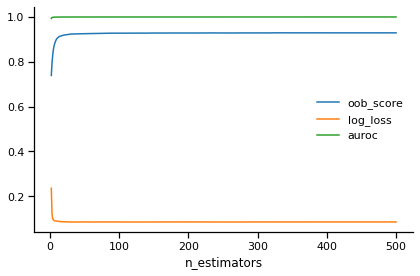

time: 10h 30min 45s


In [7]:
results = {"n_estimators": [], "oob_score": [], "log_loss": [], "auroc": []}
make_rf = lambda n_estimators: RandomForestClassifier(
    n_estimators=n_estimators,
    criterion="entropy",
    max_features="sqrt",
    random_state=SEED,
    # verbose=1,
    max_depth=15,
    bootstrap=True,
    oob_score=True,
    n_jobs=-1,
    class_weight="balanced_subsample",
)

for n in tqdm(range(2, 501)):
    model = make_rf(n).fit(data, y_true)
    results["n_estimators"].append(n)
    results["oob_score"].append(model.oob_score_)
    results["auroc"].append(
        roc_auc_score(y_true, y_pred := model.predict_proba(data), multi_class="ovo")
    )
    results["log_loss"].append(log_loss(y_true, y_pred))

# save results
df = pd.DataFrame(results).sort_values(by="n_estimators", ascending=True)
print(df.sort_values(by="oob_score", ascending=False).head(10))
print(df.sort_values(by="log_loss", ascending=True).head(10))
df.columns = df.columns.astype(str)
df.reset_index().to_feather(f"{DATA_OUT_FOLDER}/RF_n_estimators_results.feather")

# plot
df.plot(x="n_estimators")
plt.legend(frameon=False)
sns.despine(top=True, right=True)
plt.tight_layout()
plt.show()

In [9]:
print(df.sort_values(by="auroc", ascending=False).head(10))
_ = gc_collect()

     n_estimators  oob_score  log_loss     auroc
486           488   0.928912  0.085608  0.999732
487           489   0.928947  0.085604  0.999732
497           499   0.928947  0.085596  0.999732
488           490   0.928843  0.085598  0.999732
489           491   0.928855  0.085600  0.999732
498           500   0.928901  0.085607  0.999732
485           487   0.928924  0.085625  0.999732
496           498   0.929005  0.085598  0.999731
495           497   0.929005  0.085598  0.999731
484           486   0.928889  0.085618  0.999731
time: 178 ms


# max_depth

  0%|          | 0/100 [00:00<?, ?it/s]

    max_depth  oob_score  log_loss     auroc
18         19   0.925996  0.056618  0.999997
22         23   0.925938  0.051203  1.000000
16         17   0.925835  0.066665  0.999950
15         16   0.925673  0.074872  0.999865
17         18   0.925604  0.060780  0.999986
21         22   0.925466  0.051970  1.000000
19         20   0.925466  0.054743  0.999998
24         25   0.925397  0.050571  1.000000
27         28   0.925339  0.050232  1.000000
14         15   0.925304  0.085769  0.999657
    max_depth  oob_score  log_loss  auroc
49         50    0.92482   0.05019    1.0
72         73    0.92482   0.05019    1.0
71         72    0.92482   0.05019    1.0
70         71    0.92482   0.05019    1.0
69         70    0.92482   0.05019    1.0
68         69    0.92482   0.05019    1.0
67         68    0.92482   0.05019    1.0
66         67    0.92482   0.05019    1.0
65         66    0.92482   0.05019    1.0
64         65    0.92482   0.05019    1.0
    max_depth  oob_score  log_loss  auroc
2

<AxesSubplot:xlabel='max_depth'>

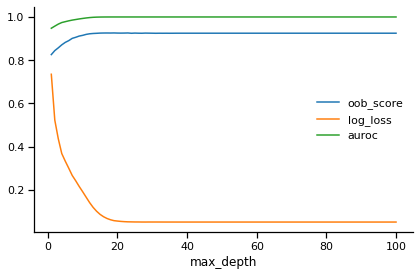

time: 26min 45s


In [10]:
results = {"max_depth": [], "oob_score": [], "log_loss": [], "auroc": []}
make_rf = lambda max_depth: RandomForestClassifier(
    n_estimators=50,
    criterion="entropy",
    max_features="sqrt",
    random_state=SEED,
    # verbose=1,
    max_depth=max_depth,
    bootstrap=True,
    oob_score=True,
    n_jobs=-1,
    class_weight="balanced_subsample",
)

for n in tqdm(range(1, 101)):
    model = make_rf(n).fit(data, y_true)
    results["max_depth"].append(n)
    results["oob_score"].append(model.oob_score_)
    results["auroc"].append(
        roc_auc_score(y_true, y_pred := model.predict_proba(data), multi_class="ovo")
    )
    results["log_loss"].append(log_loss(y_true, y_pred))

# save results
df = pd.DataFrame(results).sort_values(by="max_depth", ascending=True)
print(df.sort_values(by="oob_score", ascending=False).head(10))
print(df.sort_values(by="log_loss", ascending=True).head(10))
print(df.sort_values(by="auroc", ascending=False).head(10))
df.columns = df.columns.astype(str)
df.reset_index().to_feather(f"{DATA_OUT_FOLDER}/RF_max_depth_results.feather")

# plot
df.plot(x="max_depth")
plt.legend(frameon=False)
sns.despine(top=True, right=True)
plt.tight_layout()
plt.show()

All these OOB score are lower than the previous tuning run for n_estimators (probably because we capped at 50 trees). But many candidates have been achieving AUROC of ~100%. This is almost definitely overfit.

    max_depth  oob_score  log_loss     auroc
18         19   0.925996  0.056618  0.999997
22         23   0.925938  0.051203  1.000000
16         17   0.925835  0.066665  0.999950
15         16   0.925673  0.074872  0.999865
17         18   0.925604  0.060780  0.999986
21         22   0.925466  0.051970  1.000000
19         20   0.925466  0.054743  0.999998
24         25   0.925397  0.050571  1.000000
14         15   0.925304  0.085769  0.999657
20         21   0.925212  0.053089  1.000000
    max_depth  oob_score  log_loss     auroc
24         25   0.925397  0.050571  1.000000
23         24   0.924509  0.050923  1.000000
22         23   0.925938  0.051203  1.000000
21         22   0.925466  0.051970  1.000000
20         21   0.925212  0.053089  1.000000
19         20   0.925466  0.054743  0.999998
18         19   0.925996  0.056618  0.999997
17         18   0.925604  0.060780  0.999986
16         17   0.925835  0.066665  0.999950
15         16   0.925673  0.074872  0.999865
    max_de

<AxesSubplot:xlabel='max_depth'>

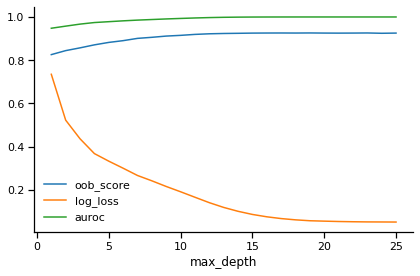

time: 251 ms


In [11]:
df = pd.read_feather(f"{DATA_OUT_FOLDER}/RF_max_depth_results.feather").drop(
    "index", axis="columns"
)
df = df.sort_values(by="max_depth", ascending=True).loc[df.max_depth <= 25]

print(df.sort_values(by="oob_score", ascending=False).head(10))
print(df.sort_values(by="log_loss", ascending=True).head(10))
print(df.sort_values(by="auroc", ascending=False).head(10))

# plot
df.plot(x="max_depth")
plt.legend(frameon=False)
sns.despine(top=True, right=True)
plt.tight_layout()
plt.show()

max_depth should not exceed 20

# min_samples_split

  0%|          | 0/99 [00:00<?, ?it/s]

    min_samples_split  oob_score  log_loss     auroc
7                   9   0.925604  0.088716  0.999654
2                   4   0.925408  0.070834  0.999922
12                 14   0.925362  0.102778  0.999298
9                  11   0.925327  0.095054  0.999533
6                   8   0.925281  0.085035  0.999740
4                   6   0.925235  0.077956  0.999856
10                 12   0.925178  0.098366  0.999442
5                   7   0.925062  0.081660  0.999803
16                 18   0.925051  0.113277  0.998893
8                  10   0.924878  0.092053  0.999610
   min_samples_split  oob_score  log_loss     auroc
0                  2   0.924140  0.066658  0.999943
1                  3   0.923506  0.067989  0.999941
2                  4   0.925408  0.070834  0.999922
3                  5   0.924301  0.073628  0.999908
4                  6   0.925235  0.077956  0.999856
5                  7   0.925062  0.081660  0.999803
6                  8   0.925281  0.085035  0.999740
7

<AxesSubplot:xlabel='min_samples_split'>

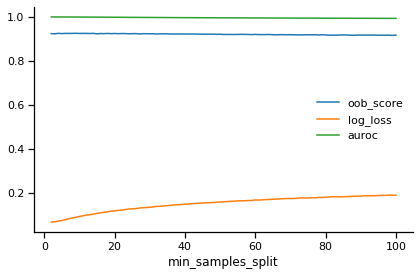

time: 20min 34s


In [12]:
results = {"min_samples_split": [], "oob_score": [], "log_loss": [], "auroc": []}
make_rf = lambda min_samples_split: RandomForestClassifier(
    n_estimators=40,  # reduced for now to speed up training
    criterion="entropy",
    max_features="sqrt",
    random_state=SEED,
    # verbose=1,
    max_depth=17,
    min_samples_split=min_samples_split,
    bootstrap=True,
    oob_score=True,
    n_jobs=-1,
    class_weight="balanced_subsample",
)

for n in tqdm(range(2, 101)):
    model = make_rf(n).fit(data, y_true)
    results["min_samples_split"].append(n)
    results["oob_score"].append(model.oob_score_)
    results["auroc"].append(
        roc_auc_score(y_true, y_pred := model.predict_proba(data), multi_class="ovo")
    )
    results["log_loss"].append(log_loss(y_true, y_pred))

# save results
df = pd.DataFrame(results).sort_values(by="min_samples_split", ascending=True)
print(df.sort_values(by="oob_score", ascending=False).head(10))
print(df.sort_values(by="log_loss", ascending=True).head(10))
print(df.sort_values(by="auroc", ascending=False).head(10))
df.columns = df.columns.astype(str)
df.reset_index().to_feather(f"{DATA_OUT_FOLDER}/RF_min_samples_split_results.feather")

# plot
df.plot(x="min_samples_split")
plt.legend(frameon=False)
sns.despine(top=True, right=True)
plt.tight_layout()
plt.show()

5 could be a good balance between log_loss and oob_score

# min_samples_leaf

  0%|          | 0/100 [00:00<?, ?it/s]

   min_samples_leaf  oob_score  log_loss     auroc
0                 1   0.925604  0.088716  0.999654
3                 4   0.925443  0.101632  0.999289
2                 3   0.925420  0.097474  0.999413
1                 2   0.925339  0.092826  0.999550
4                 5   0.924728  0.109063  0.999019
6                 7   0.924624  0.124220  0.998295
5                 6   0.924417  0.117002  0.998637
7                 8   0.924221  0.130054  0.997936
8                 9   0.923310  0.134921  0.997592
9                10   0.922884  0.140937  0.997266
   min_samples_leaf  oob_score  log_loss     auroc
0                 1   0.925604  0.088716  0.999654
1                 2   0.925339  0.092826  0.999550
2                 3   0.925420  0.097474  0.999413
3                 4   0.925443  0.101632  0.999289
4                 5   0.924728  0.109063  0.999019
5                 6   0.924417  0.117002  0.998637
6                 7   0.924624  0.124220  0.998295
7                 8   0.924221 

<AxesSubplot:xlabel='min_samples_leaf'>

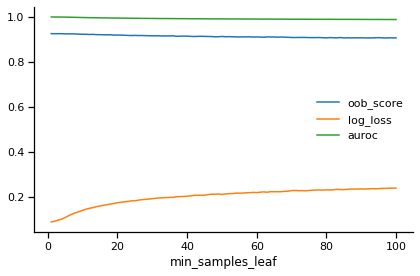

time: 18min 44s


In [13]:
results = {"min_samples_leaf": [], "oob_score": [], "log_loss": [], "auroc": []}
make_rf = lambda min_samples_leaf: RandomForestClassifier(
    n_estimators=40,  # reduced for now to speed up training
    criterion="entropy",
    max_features="sqrt",
    random_state=SEED,
    # verbose=1,
    max_depth=17,
    min_samples_split=9,
    min_samples_leaf=min_samples_leaf,
    bootstrap=True,
    oob_score=True,
    n_jobs=-1,
    class_weight="balanced_subsample",
)

for n in tqdm(range(1, 101)):
    model = make_rf(n).fit(data, y_true)
    results["min_samples_leaf"].append(n)
    results["oob_score"].append(model.oob_score_)
    results["auroc"].append(
        roc_auc_score(y_true, y_pred := model.predict_proba(data), multi_class="ovo")
    )
    results["log_loss"].append(log_loss(y_true, y_pred))

# save results
df = pd.DataFrame(results).sort_values(by="min_samples_leaf", ascending=True)
print(df.sort_values(by="oob_score", ascending=False).head(10))
print(df.sort_values(by="log_loss", ascending=True).head(10))
print(df.sort_values(by="auroc", ascending=False).head(10))
df.columns = df.columns.astype(str)
df.reset_index().to_feather(f"{DATA_OUT_FOLDER}/RF_min_samples_leaf_results.feather")

# plot
df.plot(x="min_samples_leaf")
plt.legend(frameon=False)
sns.despine(top=True, right=True)
plt.tight_layout()
plt.show()

# max_leaf_nodes

  0%|          | 0/54 [00:00<?, ?it/s]

    max_leaf_nodes  oob_score  log_loss     auroc
51           99999   0.925443  0.101632  0.999289
53           10000   0.925154  0.102187  0.999269
52            1000   0.922434  0.144425  0.996622
50             100   0.903795  0.257399  0.986195
49              99   0.903622  0.257816  0.986156
48              98   0.903541  0.258181  0.986113
47              97   0.903380  0.258524  0.986076
46              96   0.903230  0.258994  0.986027
42              92   0.903103  0.260742  0.985827
40              90   0.902988  0.261791  0.985710
    max_leaf_nodes  oob_score  log_loss     auroc
51           99999   0.925443  0.101632  0.999289
53           10000   0.925154  0.102187  0.999269
52            1000   0.922434  0.144425  0.996622
50             100   0.903795  0.257399  0.986195
49              99   0.903622  0.257816  0.986156
48              98   0.903541  0.258181  0.986113
47              97   0.903380  0.258524  0.986076
46              96   0.903230  0.258994  0.986027


<AxesSubplot:xlabel='max_leaf_nodes'>

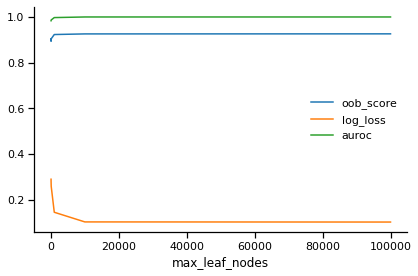

time: 8min 41s


In [14]:
results = {"max_leaf_nodes": [], "oob_score": [], "log_loss": [], "auroc": []}
make_rf = lambda max_leaf_nodes: RandomForestClassifier(
    n_estimators=40,  # reduced for now to speed up training
    criterion="entropy",
    max_features="sqrt",
    max_leaf_nodes=max_leaf_nodes,
    random_state=SEED,
    # verbose=1,
    max_depth=17,
    min_samples_split=9,
    min_samples_leaf=4,
    bootstrap=True,
    oob_score=True,
    n_jobs=-1,
    class_weight="balanced_subsample",
)

for n in tqdm(list(range(50, 101)) + [None, 1000, 10000]):
    model = make_rf(n).fit(data, y_true)
    results["max_leaf_nodes"].append(
        n if n else 99999
    )  # None means unlimited number of leaf nodes
    results["oob_score"].append(model.oob_score_)
    results["auroc"].append(
        roc_auc_score(y_true, y_pred := model.predict_proba(data), multi_class="ovo")
    )
    results["log_loss"].append(log_loss(y_true, y_pred))

# save results
df = pd.DataFrame(results).sort_values(by="max_leaf_nodes", ascending=True)
print(df.sort_values(by="oob_score", ascending=False).head(10))
print(df.sort_values(by="log_loss", ascending=True).head(10))
print(df.sort_values(by="auroc", ascending=False).head(10))
df.columns = df.columns.astype(str)
df.reset_index().to_feather(f"{DATA_OUT_FOLDER}/RF_max_leaf_nodes_results.feather")

# plot
df.plot(x="max_leaf_nodes")
plt.legend(frameon=False)
sns.despine(top=True, right=True)
plt.tight_layout()
plt.show()

  0%|          | 0/13 [00:00<?, ?it/s]

   max_leaf_nodes  oob_score  log_loss     auroc
0           99999   0.925443  0.101632  0.999289
1           10000   0.925154  0.102187  0.999269
2           11000   0.925154  0.102187  0.999269
3           12000   0.925154  0.102187  0.999269
4           13000   0.925154  0.102187  0.999269
5           14000   0.925154  0.102187  0.999269
6           15000   0.925154  0.102187  0.999269
7           16000   0.925154  0.102187  0.999269
8           17000   0.925154  0.102187  0.999269
9           18000   0.925154  0.102187  0.999269
   max_leaf_nodes  oob_score  log_loss     auroc
0           99999   0.925443  0.101632  0.999289
1           10000   0.925154  0.102187  0.999269
2           11000   0.925154  0.102187  0.999269
3           12000   0.925154  0.102187  0.999269
4           13000   0.925154  0.102187  0.999269
5           14000   0.925154  0.102187  0.999269
6           15000   0.925154  0.102187  0.999269
7           16000   0.925154  0.102187  0.999269
8           17000   

<AxesSubplot:xlabel='max_leaf_nodes'>

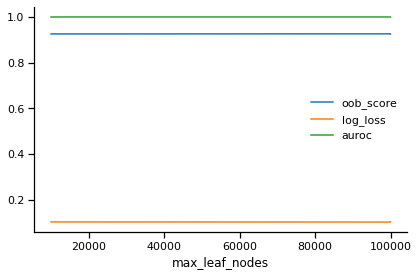

time: 2min 37s


In [15]:
results = {"max_leaf_nodes": [], "oob_score": [], "log_loss": [], "auroc": []}
make_rf = lambda max_leaf_nodes: RandomForestClassifier(
    n_estimators=40,  # reduced for now to speed up training
    criterion="entropy",
    max_features="sqrt",
    max_leaf_nodes=max_leaf_nodes,
    random_state=SEED,
    # verbose=1,
    max_depth=17,
    min_samples_split=9,
    min_samples_leaf=4,
    bootstrap=True,
    oob_score=True,
    n_jobs=-1,
    class_weight="balanced_subsample",
)

for n in tqdm(
    [
        None,
        10000,
        11000,
        12000,
        13000,
        14000,
        15000,
        16000,
        17000,
        18000,
        19000,
        20000,
        100000,
    ]
):
    model = make_rf(n).fit(data, y_true)
    results["max_leaf_nodes"].append(
        n if n else 99999
    )  # None means unlimited number of leaf nodes
    results["oob_score"].append(model.oob_score_)
    results["auroc"].append(
        roc_auc_score(y_true, y_pred := model.predict_proba(data), multi_class="ovo")
    )
    results["log_loss"].append(log_loss(y_true, y_pred))

# save results
df = pd.DataFrame(results).sort_values(by="max_leaf_nodes", ascending=True)
print(df.sort_values(by="oob_score", ascending=False).head(10))
print(df.sort_values(by="log_loss", ascending=True).head(10))
print(df.sort_values(by="auroc", ascending=False).head(10))
df.columns = df.columns.astype(str)
df.reset_index().to_feather(f"{DATA_OUT_FOLDER}/RF_max_leaf_nodes_results2.feather")

# plot
df.plot(x="max_leaf_nodes")
plt.legend(frameon=False)
sns.despine(top=True, right=True)
plt.tight_layout()
plt.show()

  0%|          | 0/11 [00:00<?, ?it/s]

    max_leaf_nodes  oob_score  log_loss     auroc
0            99999   0.925443  0.101632  0.999289
3             3000   0.925154  0.102187  0.999269
4             4000   0.925154  0.102187  0.999269
5             5000   0.925154  0.102187  0.999269
6             6000   0.925154  0.102187  0.999269
7             7000   0.925154  0.102187  0.999269
8             8000   0.925154  0.102187  0.999269
9             9000   0.925154  0.102187  0.999269
10           10000   0.925154  0.102187  0.999269
2             2000   0.924843  0.104587  0.999123
    max_leaf_nodes  oob_score  log_loss     auroc
0            99999   0.925443  0.101632  0.999289
3             3000   0.925154  0.102187  0.999269
4             4000   0.925154  0.102187  0.999269
5             5000   0.925154  0.102187  0.999269
6             6000   0.925154  0.102187  0.999269
7             7000   0.925154  0.102187  0.999269
8             8000   0.925154  0.102187  0.999269
9             9000   0.925154  0.102187  0.999269


<AxesSubplot:xlabel='max_leaf_nodes'>

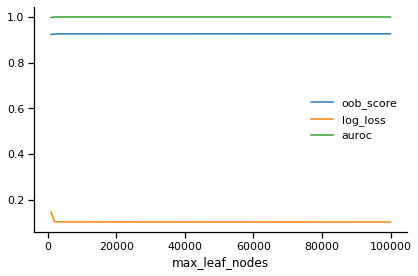

time: 2min 14s


In [16]:
results = {"max_leaf_nodes": [], "oob_score": [], "log_loss": [], "auroc": []}
make_rf = lambda max_leaf_nodes: RandomForestClassifier(
    n_estimators=40,  # reduced for now to speed up training
    criterion="entropy",
    max_features="sqrt",
    max_leaf_nodes=max_leaf_nodes,
    random_state=SEED,
    # verbose=1,
    max_depth=17,
    min_samples_split=9,
    min_samples_leaf=4,
    bootstrap=True,
    oob_score=True,
    n_jobs=-1,
    class_weight="balanced_subsample",
)

for n in tqdm(
    [
        None,
        1000,
        2000,
        3000,
        4000,
        5000,
        6000,
        7000,
        8000,
        9000,
        10000,
    ]
):
    model = make_rf(n).fit(data, y_true)
    results["max_leaf_nodes"].append(
        n if n else 99999
    )  # None means unlimited number of leaf nodes
    results["oob_score"].append(model.oob_score_)
    results["auroc"].append(
        roc_auc_score(y_true, y_pred := model.predict_proba(data), multi_class="ovo")
    )
    results["log_loss"].append(log_loss(y_true, y_pred))

# save results
df = pd.DataFrame(results).sort_values(by="max_leaf_nodes", ascending=True)
print(df.sort_values(by="oob_score", ascending=False).head(10))
print(df.sort_values(by="log_loss", ascending=True).head(10))
print(df.sort_values(by="auroc", ascending=False).head(10))
df.columns = df.columns.astype(str)
df.reset_index().to_feather(f"{DATA_OUT_FOLDER}/RF_max_leaf_nodes_results3.feather")

# plot
df.plot(x="max_leaf_nodes")
plt.legend(frameon=False)
sns.despine(top=True, right=True)
plt.tight_layout()
plt.show()

  0%|          | 0/8 [00:00<?, ?it/s]

   max_leaf_nodes  oob_score  log_loss     auroc
7            2000   0.924843  0.104587  0.999123
6            1750   0.924636  0.110077  0.998803
5            1500   0.923956  0.118567  0.998298
4            1250   0.923391  0.129869  0.997599
3            1000   0.922434  0.144425  0.996622
2             750   0.920717  0.162819  0.995267
1             500   0.917662  0.185834  0.993355
0             250   0.912002  0.219581  0.990163
   max_leaf_nodes  oob_score  log_loss     auroc
7            2000   0.924843  0.104587  0.999123
6            1750   0.924636  0.110077  0.998803
5            1500   0.923956  0.118567  0.998298
4            1250   0.923391  0.129869  0.997599
3            1000   0.922434  0.144425  0.996622
2             750   0.920717  0.162819  0.995267
1             500   0.917662  0.185834  0.993355
0             250   0.912002  0.219581  0.990163
   max_leaf_nodes  oob_score  log_loss     auroc
7            2000   0.924843  0.104587  0.999123
6            1750   

<AxesSubplot:xlabel='max_leaf_nodes'>

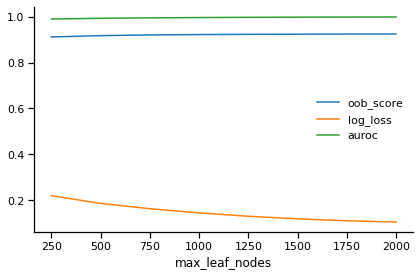

time: 1min 43s


In [18]:
results = {"max_leaf_nodes": [], "oob_score": [], "log_loss": [], "auroc": []}
make_rf = lambda max_leaf_nodes: RandomForestClassifier(
    n_estimators=40,  # reduced for now to speed up training
    criterion="entropy",
    max_features="sqrt",
    max_leaf_nodes=max_leaf_nodes,
    random_state=SEED,
    # verbose=1,
    max_depth=17,
    min_samples_split=9,
    min_samples_leaf=4,
    bootstrap=True,
    oob_score=True,
    n_jobs=-1,
    class_weight="balanced_subsample",
)

for n in tqdm(
    [
        250,
        500,
        750,
        1000,
        1250,
        1500,
        1750,
        2000,
    ]
):
    model = make_rf(n).fit(data, y_true)
    results["max_leaf_nodes"].append(
        n if n else 99999
    )  # None means unlimited number of leaf nodes
    results["oob_score"].append(model.oob_score_)
    results["auroc"].append(
        roc_auc_score(y_true, y_pred := model.predict_proba(data), multi_class="ovo")
    )
    results["log_loss"].append(log_loss(y_true, y_pred))

# save results
df = pd.DataFrame(results).sort_values(by="max_leaf_nodes", ascending=True)
print(df.sort_values(by="oob_score", ascending=False).head(10))
print(df.sort_values(by="log_loss", ascending=True).head(10))
print(df.sort_values(by="auroc", ascending=False).head(10))
df.columns = df.columns.astype(str)
df.reset_index().to_feather(f"{DATA_OUT_FOLDER}/RF_max_leaf_nodes_results4.feather")

# plot
df.plot(x="max_leaf_nodes")
plt.legend(frameon=False)
sns.despine(top=True, right=True)
plt.tight_layout()
plt.show()

  0%|          | 0/21 [00:00<?, ?it/s]

    max_leaf_nodes  oob_score  log_loss     auroc
2             2200   0.925224  0.102504  0.999247
3             2300   0.925178  0.102215  0.999267
10            3000   0.925154  0.102187  0.999269
12            3200   0.925154  0.102187  0.999269
19            3900   0.925154  0.102187  0.999269
18            3800   0.925154  0.102187  0.999269
17            3700   0.925154  0.102187  0.999269
16            3600   0.925154  0.102187  0.999269
15            3500   0.925154  0.102187  0.999269
14            3400   0.925154  0.102187  0.999269
    max_leaf_nodes  oob_score  log_loss     auroc
10            3000   0.925154  0.102187  0.999269
18            3800   0.925154  0.102187  0.999269
17            3700   0.925154  0.102187  0.999269
16            3600   0.925154  0.102187  0.999269
15            3500   0.925154  0.102187  0.999269
14            3400   0.925154  0.102187  0.999269
13            3300   0.925154  0.102187  0.999269
12            3200   0.925154  0.102187  0.999269


<AxesSubplot:xlabel='max_leaf_nodes'>

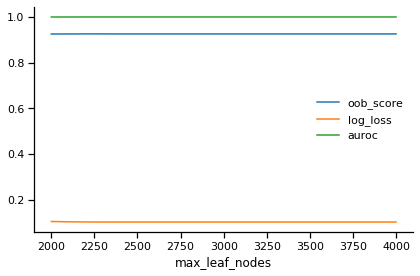

time: 4min 29s


In [21]:
results = {"max_leaf_nodes": [], "oob_score": [], "log_loss": [], "auroc": []}
make_rf = lambda max_leaf_nodes: RandomForestClassifier(
    n_estimators=40,  # reduced for now to speed up training
    criterion="entropy",
    max_features="sqrt",
    max_leaf_nodes=max_leaf_nodes,
    random_state=SEED,
    # verbose=1,
    max_depth=17,
    min_samples_split=9,
    min_samples_leaf=4,
    bootstrap=True,
    oob_score=True,
    n_jobs=-1,
    class_weight="balanced_subsample",
)

for n in tqdm([100 * i for i in range(20, 41)]):
    model = make_rf(n).fit(data, y_true)
    results["max_leaf_nodes"].append(
        n if n else 99999
    )  # None means unlimited number of leaf nodes
    results["oob_score"].append(model.oob_score_)
    results["auroc"].append(
        roc_auc_score(y_true, y_pred := model.predict_proba(data), multi_class="ovo")
    )
    results["log_loss"].append(log_loss(y_true, y_pred))

# save results
df = pd.DataFrame(results).sort_values(by="max_leaf_nodes", ascending=True)
print(df.sort_values(by="oob_score", ascending=False).head(10))
print(df.sort_values(by="log_loss", ascending=True).head(10))
print(df.sort_values(by="auroc", ascending=False).head(10))
df.columns = df.columns.astype(str)
df.reset_index().to_feather(f"{DATA_OUT_FOLDER}/RF_max_leaf_nodes_results5.feather")

# plot
df.plot(x="max_leaf_nodes")
plt.legend(frameon=False)
sns.despine(top=True, right=True)
plt.tight_layout()
plt.show()

  0%|          | 0/7 [00:00<?, ?it/s]

   max_leaf_nodes  oob_score  log_loss     auroc
1            2250   0.925189  0.102310  0.999260
2            2500   0.925154  0.102187  0.999269
3            2750   0.925154  0.102187  0.999269
4            3000   0.925154  0.102187  0.999269
5            3250   0.925154  0.102187  0.999269
6            3500   0.925154  0.102187  0.999269
0            2000   0.924843  0.104587  0.999123
   max_leaf_nodes  oob_score  log_loss     auroc
2            2500   0.925154  0.102187  0.999269
3            2750   0.925154  0.102187  0.999269
4            3000   0.925154  0.102187  0.999269
5            3250   0.925154  0.102187  0.999269
6            3500   0.925154  0.102187  0.999269
1            2250   0.925189  0.102310  0.999260
0            2000   0.924843  0.104587  0.999123
   max_leaf_nodes  oob_score  log_loss     auroc
2            2500   0.925154  0.102187  0.999269
3            2750   0.925154  0.102187  0.999269
4            3000   0.925154  0.102187  0.999269
5            3250   

<AxesSubplot:xlabel='max_leaf_nodes'>

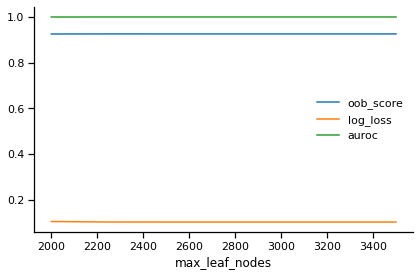

time: 1min 28s


In [24]:
results = {"max_leaf_nodes": [], "oob_score": [], "log_loss": [], "auroc": []}
make_rf = lambda max_leaf_nodes: RandomForestClassifier(
    n_estimators=40,  # reduced for now to speed up training
    criterion="entropy",
    max_features="sqrt",
    max_leaf_nodes=max_leaf_nodes,
    random_state=SEED,
    # verbose=1,
    max_depth=17,
    min_samples_split=9,
    min_samples_leaf=4,
    bootstrap=True,
    oob_score=True,
    n_jobs=-1,
    class_weight="balanced_subsample",
)

for n in tqdm([2000, 2250, 2500, 2750, 3000, 3250, 3500]):
    model = make_rf(n).fit(data, y_true)
    results["max_leaf_nodes"].append(
        n if n else 99999
    )  # None means unlimited number of leaf nodes
    results["oob_score"].append(model.oob_score_)
    results["auroc"].append(
        roc_auc_score(y_true, y_pred := model.predict_proba(data), multi_class="ovo")
    )
    results["log_loss"].append(log_loss(y_true, y_pred))

# save results
df = pd.DataFrame(results).sort_values(by="max_leaf_nodes", ascending=True)
print(df.sort_values(by="oob_score", ascending=False).head(10))
print(df.sort_values(by="log_loss", ascending=True).head(10))
print(df.sort_values(by="auroc", ascending=False).head(10))
df.columns = df.columns.astype(str)
df.reset_index().to_feather(f"{DATA_OUT_FOLDER}/RF_max_leaf_nodes_results6.feather")

# plot
df.plot(x="max_leaf_nodes")
plt.legend(frameon=False)
sns.despine(top=True, right=True)
plt.tight_layout()
plt.show()

  0%|          | 0/51 [00:00<?, ?it/s]

    max_leaf_nodes  oob_score  log_loss     auroc
21            2210   0.925247  0.102452  0.999250
20            2200   0.925224  0.102504  0.999247
27            2270   0.925201  0.102266  0.999263
26            2260   0.925201  0.102285  0.999262
24            2240   0.925201  0.102338  0.999258
22            2220   0.925201  0.102413  0.999253
25            2250   0.925189  0.102310  0.999260
17            2170   0.925189  0.102692  0.999236
23            2230   0.925189  0.102374  0.999255
30            2300   0.925178  0.102215  0.999267
    max_leaf_nodes  oob_score  log_loss     auroc
50            2500   0.925154  0.102187  0.999269
39            2390   0.925154  0.102187  0.999269
40            2400   0.925154  0.102187  0.999269
41            2410   0.925154  0.102187  0.999269
42            2420   0.925154  0.102187  0.999269
43            2430   0.925154  0.102187  0.999269
49            2490   0.925154  0.102187  0.999269
45            2450   0.925154  0.102187  0.999269


<AxesSubplot:xlabel='max_leaf_nodes'>

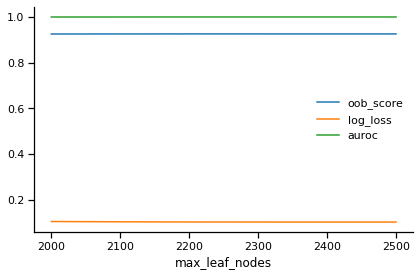

time: 11min 6s


In [25]:
results = {"max_leaf_nodes": [], "oob_score": [], "log_loss": [], "auroc": []}
make_rf = lambda max_leaf_nodes: RandomForestClassifier(
    n_estimators=40,  # reduced for now to speed up training
    criterion="entropy",
    max_features="sqrt",
    max_leaf_nodes=max_leaf_nodes,
    random_state=SEED,
    # verbose=1,
    max_depth=17,
    min_samples_split=9,
    min_samples_leaf=4,
    bootstrap=True,
    oob_score=True,
    n_jobs=-1,
    class_weight="balanced_subsample",
)

for n in tqdm([10 * i for i in range(200, 251)]):
    model = make_rf(n).fit(data, y_true)
    results["max_leaf_nodes"].append(
        n if n else 99999
    )  # None means unlimited number of leaf nodes
    results["oob_score"].append(model.oob_score_)
    results["auroc"].append(
        roc_auc_score(y_true, y_pred := model.predict_proba(data), multi_class="ovo")
    )
    results["log_loss"].append(log_loss(y_true, y_pred))

# save results
df = pd.DataFrame(results).sort_values(by="max_leaf_nodes", ascending=True)
print(df.sort_values(by="oob_score", ascending=False).head(10))
print(df.sort_values(by="log_loss", ascending=True).head(10))
print(df.sort_values(by="auroc", ascending=False).head(10))
df.columns = df.columns.astype(str)
df.reset_index().to_feather(f"{DATA_OUT_FOLDER}/RF_max_leaf_nodes_results7.feather")

# plot
df.plot(x="max_leaf_nodes")
plt.legend(frameon=False)
sns.despine(top=True, right=True)
plt.tight_layout()
plt.show()

  0%|          | 0/31 [00:00<?, ?it/s]

    max_leaf_nodes  oob_score  log_loss     auroc
7             2207   0.925258  0.102470  0.999250
8             2208   0.925258  0.102464  0.999250
6             2206   0.925247  0.102476  0.999249
9             2209   0.925247  0.102457  0.999250
10            2210   0.925247  0.102452  0.999250
12            2212   0.925235  0.102444  0.999251
13            2213   0.925235  0.102440  0.999251
11            2211   0.925235  0.102448  0.999251
0             2200   0.925224  0.102504  0.999247
16            2216   0.925224  0.102428  0.999252
    max_leaf_nodes  oob_score  log_loss     auroc
30            2230   0.925189  0.102374  0.999255
29            2229   0.925189  0.102377  0.999255
28            2228   0.925189  0.102382  0.999255
27            2227   0.925189  0.102387  0.999255
26            2226   0.925178  0.102388  0.999254
25            2225   0.925178  0.102391  0.999254
24            2224   0.925178  0.102395  0.999254
23            2223   0.925178  0.102399  0.999254


<AxesSubplot:xlabel='max_leaf_nodes'>

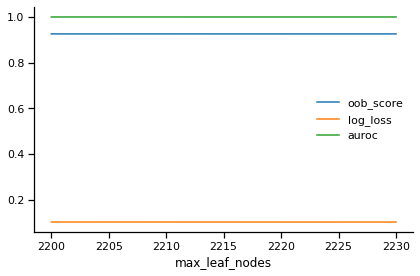

time: 6min 58s


In [27]:
results = {"max_leaf_nodes": [], "oob_score": [], "log_loss": [], "auroc": []}
make_rf = lambda max_leaf_nodes: RandomForestClassifier(
    n_estimators=40,  # reduced for now to speed up training
    criterion="entropy",
    max_features="sqrt",
    max_leaf_nodes=max_leaf_nodes,
    random_state=SEED,
    # verbose=1,
    max_depth=17,
    min_samples_split=9,
    min_samples_leaf=4,
    bootstrap=True,
    oob_score=True,
    n_jobs=-1,
    class_weight="balanced_subsample",
)

for n in tqdm(range(2200, 2231)):
    model = make_rf(n).fit(data, y_true)
    results["max_leaf_nodes"].append(
        n if n else 99999
    )  # None means unlimited number of leaf nodes
    results["oob_score"].append(model.oob_score_)
    results["auroc"].append(
        roc_auc_score(y_true, y_pred := model.predict_proba(data), multi_class="ovo")
    )
    results["log_loss"].append(log_loss(y_true, y_pred))

# save results
df = pd.DataFrame(results).sort_values(by="max_leaf_nodes", ascending=True)
print(df.sort_values(by="oob_score", ascending=False).head(10))
print(df.sort_values(by="log_loss", ascending=True).head(10))
print(df.sort_values(by="auroc", ascending=False).head(10))
df.columns = df.columns.astype(str)
df.reset_index().to_feather(f"{DATA_OUT_FOLDER}/RF_max_leaf_nodes_results8.feather")

# plot
df.plot(x="max_leaf_nodes")
plt.legend(frameon=False)
sns.despine(top=True, right=True)
plt.tight_layout()
plt.show()

# Prototype

In [28]:
new_rf = RandomForestClassifier(
    n_estimators=342,
    criterion="entropy",
    max_features="sqrt",
    max_leaf_nodes=2207,
    random_state=SEED,
    verbose=1,
    max_depth=17,
    min_samples_split=9,
    min_samples_leaf=4,
    bootstrap=True,
    oob_score=True,
    n_jobs=-1,
    class_weight="balanced_subsample",
).fit(data, y_true)

print("oob score", new_rf.oob_score_)
print("log loss", log_loss(y_true, y_pred := new_rf.predict_proba(data)))
print("auroc", roc_auc_score(y_true, y_pred, multi_class="ovo"))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   56.9s
[Parallel(n_jobs=-1)]: Done 342 out of 342 | elapsed:  1.8min finished


oob score 0.9298575248985614


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.6s


log loss 0.10173454830189305
auroc 0.9993727894991012
time: 1min 59s


[Parallel(n_jobs=8)]: Done 342 out of 342 | elapsed:    1.1s finished


# Discussion

Most of these hyperparameters, usually the ones with "min" or "max" in the name, just need to be set more than they need to be tuned. We just don't want overgrown trees, so we do some light tuning w/o cross validation.

I had read earlier that increasing the number of trees in a random forest doesn't increase propensity for overfitting; overfitting is capped, so to speak. We really just had to find the plateau point, but it looks like we went beyond by a couple hundred trees, which is okay. The best score for each of the three metrics was obtained with > 300 trees, well past the plateau point.

We could choose 100 trees since that is a nice number that is also past the plateau point.

max depth should be less than 20; 

edit:  this is old: min_samples_split at 2 yields the best loss and auroc, but oob score is better when this number is a little higher, up to 11. 5 seems to be a good balance

min_samples_leaf should be < 10

focusing on oob score, max_leaf_nodes should be set around 2700

I can't figure out why my feature names aren't valid. When I was looking at tree importances with ExtraTrees and AdaBoost, I would sometimes get similar messages and sometimes not. As far as I can tell, I'm fitting, transforming, and predicting with the same consistent set of string-valued feature names. I even tried replacing the "+" character in a different notebook and am still getting these warnings. I think it may be a bug?

There are so many more possibilities for feature engineering. Upstream augmentation of the raw audio would probably be helpful as would resampling.

It's important to be disciplined now and focus on deployment. Although there are numerous points of interest where tweaking is likely to yield better results, we are only deviating slightly from the feature engineering pathway we already established.

In [29]:
print(f"Time elapsed since notebook_begin_time: {time() - notebook_begin_time} s")
_ = gc_collect()

Time elapsed since notebook_begin_time: 86015.73464202881 s
time: 147 ms


[^top](#Contents)